In [1]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../../src')
import harmoutil
from custom_callbacks import MultiAccuracyBestPerformanceCheckpoint
%matplotlib inline

/home/maxime/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# # Remove when done with kernel
import importlib
importlib.reload(harmoutil)

<module 'harmoutil' from '../../../src/harmoutil.py'>

In [3]:
### Load raw data ###
raw_data = harmoutil.load_pickled_data("../../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections

### Augment data ###
augmented_data = harmoutil.transpose_and_augment_data(raw_data)

data = [harmoutil.to_triads(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

chords = [ch for section in data for ch, mel in section]
roots, suffixes = harmoutil.roots_and_suffixes(chords) # added for model 2
melodies_by_beats = [mel for section in data for ch, mel in section]

melodies_by_notes = []
for mel in melodies_by_beats:
    melodies_by_notes.append([n for b in mel for n in b])
notes = [n for sec in melodies_by_notes for n in sec]
print(len(chords), len(melodies_by_beats), len(melodies_by_notes), len(notes))

334344 334344 334344 2209944


In [4]:
### Define class integer mappings ###

# Melody notes labels
notes_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(notes)))[1:])])
notes_index[-1] = len(notes_index)
notes_index['<end>'] = len(notes_index)
notes_index['<pad>'] = len(notes_index)

index_notes = dict(
    [(v, k) for k, v in notes_index.items()])


# Chord labels
chords_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(chords))))])
chords_index['<bos>'] = len(chords_index)
chords_index['<eos>'] = len(chords_index)

index_chords = dict(
    [(v, k) for k, v in chords_index.items()])


# Root labels
roots_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(roots))))])
roots_index['<bos>'] = len(roots_index)
roots_index['<eos>'] = len(roots_index)

index_roots = dict(
    [(v, k) for k, v in roots_index.items()])


# Suffix labels
suffixes_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(suffixes))))])
suffixes_index['<bos>'] = len(suffixes_index)
suffixes_index['<eos>'] = len(suffixes_index)

index_suffixes = dict(
    [(v, k) for k, v in suffixes_index.items()])

print(notes_index)
print(index_notes)
print(roots_index)
print(index_roots)
print(suffixes_index)
print(index_suffixes)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<end>': 13, -1: 12, '<pad>': 14}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<end>', 14: '<pad>'}
{'G': 10, 'C': 4, 'NC': 12, 'Gb': 11, 'E': 7, 'D': 5, '<eos>': 14, 'B': 2, 'Eb': 8, 'Db': 6, 'Ab': 1, 'A': 0, 'Bb': 3, '<bos>': 13, 'F': 9}
{0: 'A', 1: 'Ab', 2: 'B', 3: 'Bb', 4: 'C', 5: 'D', 6: 'Db', 7: 'E', 8: 'Eb', 9: 'F', 10: 'G', 11: 'Gb', 12: 'NC', 13: '<bos>', 14: '<eos>'}
{'': 0, '+': 1, 'sus': 4, '-': 2, 'o': 3, '<bos>': 5, '<eos>': 6}
{0: '', 1: '+', 2: '-', 3: 'o', 4: 'sus', 5: '<bos>', 6: '<eos>'}


In [5]:
### Numerical variables ###
n_chords = len(chords_index)
n_notes = len(notes_index)
n_roots = len(roots_index)
n_suffixes = len(suffixes_index)
max_melody_seq_len = max([len(mel) for mel in melodies_by_notes])
max_chords_seq_len = max([len(section) for section in data])
ch_context_window = 7


print("Total number of distinct chord labels:", n_chords)
print("Total number of distinct root labels", n_roots)
print("Total number of distinct suffix labels:", n_suffixes)
print("Total number of distinct melody notes:", n_notes)
print("Maximum length of melody sequences:", max_melody_seq_len)
print("Maximum length of chord sequences:", max_chords_seq_len)
print("Number of chords taken into account for next prediction:", ch_context_window)

Total number of distinct chord labels: 63
Total number of distinct root labels 15
Total number of distinct suffix labels: 7
Total number of distinct melody notes: 15
Maximum length of melody sequences: 135
Maximum length of chord sequences: 58
Number of chords taken into account for next prediction: 7


In [6]:
### Build tensors ###

# Build data lists
input_melody_eos = []
input_chords_eos = []
input_roots_eos = []
input_suffixes_eos = []
target_chords_eos = []
target_roots_eos = []
target_suffixes_eos = []

for section in data:
    chord_sequence = [ch for ch, mel in section]
    root_sequence = [harmoutil.split_root_suffix(ch)[0] for ch, mel in section]
    suffix_sequence = [harmoutil.split_root_suffix(ch)[1] for ch, mel in section]
    
    padded_root_sequence = ['<bos>']*ch_context_window + root_sequence + ['<eos>']
    padded_suffix_sequence = ['<bos>']*ch_context_window + suffix_sequence + ['<eos>']
    padded_chord_sequence = ['<bos>']*ch_context_window + chord_sequence + ['<eos>']
    for i in range(len(chord_sequence)+1):
        input_chords_eos.append(padded_chord_sequence[i:i+ch_context_window])
        target_chords_eos.append(padded_chord_sequence[i+ch_context_window])

        input_roots_eos.append(padded_root_sequence[i:i+ch_context_window])
        target_roots_eos.append(padded_root_sequence[i+ch_context_window])
        
        input_suffixes_eos.append(padded_suffix_sequence[i:i+ch_context_window])
        target_suffixes_eos.append(padded_suffix_sequence[i+ch_context_window])
        
        
    chord_mel = [mel for ch, mel in section]
    melody_sequence = []
    for mel in chord_mel:
        ch_mel = []
        for b in mel:
            for n in b:
                ch_mel.append(n)
        melody_sequence.append(ch_mel)
    melody_sequence += [['<end>']]
    input_melody_eos+= melody_sequence
    
print(len(target_chords_eos), len(input_chords_eos), len(target_roots_eos), len(input_roots_eos), len(target_suffixes_eos), len(input_suffixes_eos), len(input_melody_eos))
target_chords = [target_chords_eos[i] for i in range(len(target_chords_eos)) if not target_chords_eos[i] == '<eos>']
input_chords = [input_chords_eos[i] for i in range(len(input_chords_eos)) if not target_chords_eos[i] == '<eos>']
target_roots = [target_roots_eos[i] for i in range(len(target_roots_eos)) if not target_chords_eos[i] == '<eos>']
input_roots = [input_roots_eos[i] for i in range(len(input_roots_eos)) if not target_chords_eos[i] == '<eos>']
target_suffixes = [target_suffixes_eos[i] for i in range(len(target_suffixes_eos)) if not target_chords_eos[i] == '<eos>']
input_suffixes = [input_suffixes_eos[i] for i in range(len(input_suffixes_eos)) if not target_chords_eos[i] == '<eos>']

input_melody = [input_melody_eos[i] for i in range(len(input_melody_eos)) if not target_chords_eos[i] == '<eos>']    
print(len(target_chords), len(input_chords), len(target_roots), len(input_roots), len(target_suffixes), len(input_suffixes), len(input_melody))

n_entries = len(target_chords)

X_melody = np.zeros((n_entries, max_melody_seq_len, n_notes), dtype='float32')

X_chords = np.zeros((n_entries, ch_context_window, n_chords), dtype='float32')
X_roots = np.zeros((n_entries, ch_context_window, n_roots), dtype='float32')
X_suffixes = np.zeros((n_entries, ch_context_window, n_suffixes), dtype='float32')

Y_chords = np.zeros((n_entries, n_chords), dtype='float32')
Y_roots = np.zeros((n_entries, n_roots), dtype='float32')
Y_suffixes = np.zeros((n_entries, n_suffixes), dtype='float32')

for i, (in_mel, in_ch, tg_ch, in_rt, tg_rt, in_sf, tg_sf) in enumerate(zip(input_melody, input_chords, target_chords, input_roots, target_roots, input_suffixes, target_suffixes)):
    Y_chords[i, chords_index[tg_ch]] = 1
    Y_roots[i, roots_index[tg_rt]] = 1
    Y_suffixes[i, suffixes_index[tg_sf]] = 1
    for j, (ch, rt, sf) in enumerate(zip(in_ch, in_rt, in_sf)):
        X_chords[i, j, chords_index[ch]] = 1
        X_roots[i, j, roots_index[rt]] = 1
        X_suffixes[i, j, suffixes_index[sf]] = 1
        
    padded_melody = in_mel + ['<pad>']*(max_melody_seq_len - len(in_mel))
    for k, note in enumerate(padded_melody):
        X_melody[i, k, notes_index[note]] = 1
        
print(int(np.sum(X_melody)), n_entries*max_melody_seq_len)
print(int(np.sum(X_chords)), n_entries*ch_context_window)
print(int(np.sum(X_roots)), n_entries*ch_context_window)
print(int(np.sum(X_suffixes)), n_entries*ch_context_window)

print(int(np.sum(Y_chords)), n_entries)
print(int(np.sum(Y_roots)), n_entries)
print(int(np.sum(Y_suffixes)), n_entries)

363228 363228 363228 363228 363228 363228 363228
334344 334344 334344 334344 334344 334344 334344
45115280 45136440
2340408 2340408
2340408 2340408
2340408 2340408
334344 334344
334344 334344
334344 334344


In [7]:
### Train/Validation/Test sets ###
seed = 1

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in strat_split.split(X_chords, Y_chords):
    X_melody_train = X_melody[train_index]
    X_chords_train = X_chords[train_index]
    X_roots_train = X_roots[train_index]
    X_suffixes_train = X_suffixes[train_index]
    Y_chords_train = Y_chords[train_index]
    Y_roots_train = Y_roots[train_index]
    Y_suffixes_train = Y_suffixes[train_index]
    
    
    X_melody_aux = X_melody[aux_index]
    X_chords_aux = X_chords[aux_index]
    X_roots_aux = X_roots[aux_index]
    X_suffixes_aux = X_suffixes[aux_index]
    Y_chords_aux = Y_chords[aux_index]
    Y_roots_aux = Y_roots[aux_index]
    Y_suffixes_aux = Y_suffixes[aux_index]
    
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
for valid_index, test_index in strat_split.split(X_chords_aux, Y_chords_aux):
    X_melody_valid = X_melody_aux[valid_index]
    X_chords_valid = X_chords_aux[valid_index]
    X_roots_valid = X_roots_aux[valid_index]
    X_suffixes_valid = X_suffixes_aux[valid_index]
    Y_chords_valid = Y_chords_aux[valid_index]
    Y_roots_valid = Y_roots_aux[valid_index]
    Y_suffixes_valid = Y_suffixes_aux[valid_index]
    
    
    X_melody_test = X_melody_aux[test_index]
    X_chords_test = X_chords_aux[test_index]
    X_roots_test = X_roots_aux[test_index]
    X_suffixes_test = X_suffixes_aux[test_index]
    Y_chords_test = Y_chords_aux[test_index]
    Y_roots_test = Y_roots_aux[test_index]
    Y_suffixes_test = Y_suffixes_aux[test_index]

print(X_melody_train.shape, X_chords_train.shape, Y_chords_train.shape, X_roots_train.shape, Y_roots_train.shape, X_suffixes_train.shape, Y_suffixes_train.shape)
print(X_melody_valid.shape, X_chords_valid.shape, Y_chords_valid.shape, X_roots_valid.shape, Y_roots_valid.shape, X_suffixes_valid.shape, Y_suffixes_valid.shape)
print(X_melody_test.shape, X_chords_test.shape, Y_chords_test.shape, X_roots_test.shape, Y_roots_test.shape, X_suffixes_test.shape, Y_suffixes_test.shape)

# train_size = melody_train.shape[0]
# test_size = melody_test.shape[0]

(267475, 135, 15) (267475, 7, 63) (267475, 63) (267475, 7, 15) (267475, 15) (267475, 7, 7) (267475, 7)
(33434, 135, 15) (33434, 7, 63) (33434, 63) (33434, 7, 15) (33434, 15) (33434, 7, 7) (33434, 7)
(33435, 135, 15) (33435, 7, 63) (33435, 63) (33435, 7, 15) (33435, 15) (33435, 7, 7) (33435, 7)


In [8]:
### Define neural net architectur ###
latent_dim = 128

melody_input = Input(shape=(max_melody_seq_len, n_notes))
melody_gru = GRU(latent_dim)(melody_input)

roots_input = Input(shape=(ch_context_window, n_roots))
roots_gru = GRU(latent_dim)(roots_input)

suffixes_input = Input(shape=(ch_context_window, n_suffixes))
suffixes_gru = GRU(latent_dim)(suffixes_input)

concat = concatenate([melody_gru, roots_gru, suffixes_gru])

root_dense = Dense(n_roots, activation='softmax')(concat)
suffix_dense = Dense(n_suffixes, activation='softmax')(concat)

model = Model([melody_input, roots_input, suffixes_input], [root_dense, suffix_dense])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 135, 15)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 7, 15)         0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 7, 7)          0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 128)           55296       input_1[0][0]                    
___________________________________________________________________________________________

In [9]:
### Introduce Early-Stopping and Save Best Performance callbacks ###
# es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
# filepath = "../../models/model-2_cc-5.h5"
# bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

filepath = "../../models/model-2_cc-7.h5"
mabpc = MultiAccuracyBestPerformanceCheckpoint(filepath, monitor=['val_dense_1_acc', 'val_dense_2_acc'], verbose=1)


In [11]:
batch_size = 32
epochs = 50
history = model.fit([X_melody_train, X_roots_train, X_suffixes_train], [Y_roots_train, Y_suffixes_train], epochs=epochs, validation_data=([X_melody_valid, X_roots_valid, X_suffixes_valid], [Y_roots_valid, Y_suffixes_valid]), batch_size=batch_size, callbacks=[mabpc])#, callbacks=[es, bp])

Train on 267475 samples, validate on 33434 samples
Epoch 1/50
267456/267475 [============================>.] - ETA: 0s - loss: 2.3923 - dense_1_loss: 1.7036 - dense_2_loss: 0.6887 - dense_1_acc: 0.4834 - dense_2_acc: 0.7117
Epoch 00001: ['val_dense_1_acc', 'val_dense_2_acc'] improved from [0.0, 0.0] => -inf to [0.5026320512089253, 0.7414607884296712] => 1.24409, saving model to ../../models/model-2_cc-7.h5
267475/267475 [==============================] - 1092s - loss: 2.3922 - dense_1_loss: 1.7036 - dense_2_loss: 0.6886 - dense_1_acc: 0.4834 - dense_2_acc: 0.7118 - val_loss: 2.2314 - val_dense_1_loss: 1.6110 - val_dense_2_loss: 0.6204 - val_dense_1_acc: 0.5026 - val_dense_2_acc: 0.7415
Epoch 2/50
267456/267475 [============================>.] - ETA: 0s - loss: 2.1324 - dense_1_loss: 1.5377 - dense_2_loss: 0.5947 - dense_1_acc: 0.5201 - dense_2_acc: 0.7558
Epoch 00002: ['val_dense_1_acc', 'val_dense_2_acc'] improved from [0.5026320512089253, 0.7414607884296712] => 1.24409 to [0.53068732

267475/267475 [==============================] - 1086s - loss: 1.5843 - dense_1_loss: 1.1389 - dense_2_loss: 0.4454 - dense_1_acc: 0.6349 - dense_2_acc: 0.8236 - val_loss: 1.7276 - val_dense_1_loss: 1.2561 - val_dense_2_loss: 0.4715 - val_dense_1_acc: 0.6140 - val_dense_2_acc: 0.8177
Epoch 14/50
267456/267475 [============================>.] - ETA: 0s - loss: 1.5708 - dense_1_loss: 1.1285 - dense_2_loss: 0.4423 - dense_1_acc: 0.6384 - dense_2_acc: 0.8239
Epoch 00014: ['val_dense_1_acc', 'val_dense_2_acc'] improved from [0.6139857630171459, 0.8177005443667412] => 1.43169 to [0.6169767302710053, 0.8156666865921864] => 1.43264, saving model to ../../models/model-2_cc-7.h5
267475/267475 [==============================] - 1095s - loss: 1.5708 - dense_1_loss: 1.1285 - dense_2_loss: 0.4423 - dense_1_acc: 0.6384 - dense_2_acc: 0.8239 - val_loss: 1.7236 - val_dense_1_loss: 1.2487 - val_dense_2_loss: 0.4748 - val_dense_1_acc: 0.6170 - val_dense_2_acc: 0.8157
Epoch 15/50
267456/267475 [==========

267475/267475 [==============================] - 1093s - loss: 1.4973 - dense_1_loss: 1.0770 - dense_2_loss: 0.4203 - dense_1_acc: 0.6517 - dense_2_acc: 0.8328 - val_loss: 1.6946 - val_dense_1_loss: 1.2334 - val_dense_2_loss: 0.4612 - val_dense_1_acc: 0.6226 - val_dense_2_acc: 0.8216
Epoch 27/50
267456/267475 [============================>.] - ETA: 0s - loss: 1.4883 - dense_1_loss: 1.0700 - dense_2_loss: 0.4183 - dense_1_acc: 0.6532 - dense_2_acc: 0.8333
Epoch 00027: ['val_dense_1_acc', 'val_dense_2_acc'] did not improve from 1.45086
267475/267475 [==============================] - 1093s - loss: 1.4883 - dense_1_loss: 1.0699 - dense_2_loss: 0.4183 - dense_1_acc: 0.6532 - dense_2_acc: 0.8333 - val_loss: 1.6760 - val_dense_1_loss: 1.2146 - val_dense_2_loss: 0.4614 - val_dense_1_acc: 0.6290 - val_dense_2_acc: 0.8208
Epoch 28/50
267456/267475 [============================>.] - ETA: 0s - loss: 1.4485 - dense_1_loss: 1.0318 - dense_2_loss: 0.4167 - dense_1_acc: 0.6648 - dense_2_acc: 0.8331
E

267475/267475 [==============================] - 1086s - loss: 1.4640 - dense_1_loss: 1.0530 - dense_2_loss: 0.4110 - dense_1_acc: 0.6581 - dense_2_acc: 0.8356 - val_loss: 1.6768 - val_dense_1_loss: 1.2233 - val_dense_2_loss: 0.4535 - val_dense_1_acc: 0.6278 - val_dense_2_acc: 0.8283
Epoch 41/50
267456/267475 [============================>.] - ETA: 0s - loss: 1.4597 - dense_1_loss: 1.0492 - dense_2_loss: 0.4105 - dense_1_acc: 0.6591 - dense_2_acc: 0.8365
Epoch 00041: ['val_dense_1_acc', 'val_dense_2_acc'] did not improve from 1.46979
267475/267475 [==============================] - 1093s - loss: 1.4597 - dense_1_loss: 1.0492 - dense_2_loss: 0.4105 - dense_1_acc: 0.6591 - dense_2_acc: 0.8365 - val_loss: 1.6610 - val_dense_1_loss: 1.2058 - val_dense_2_loss: 0.4552 - val_dense_1_acc: 0.6331 - val_dense_2_acc: 0.8268
Epoch 42/50
267456/267475 [============================>.] - ETA: 0s - loss: 1.4567 - dense_1_loss: 1.0464 - dense_2_loss: 0.4103 - dense_1_acc: 0.6593 - dense_2_acc: 0.8364
E

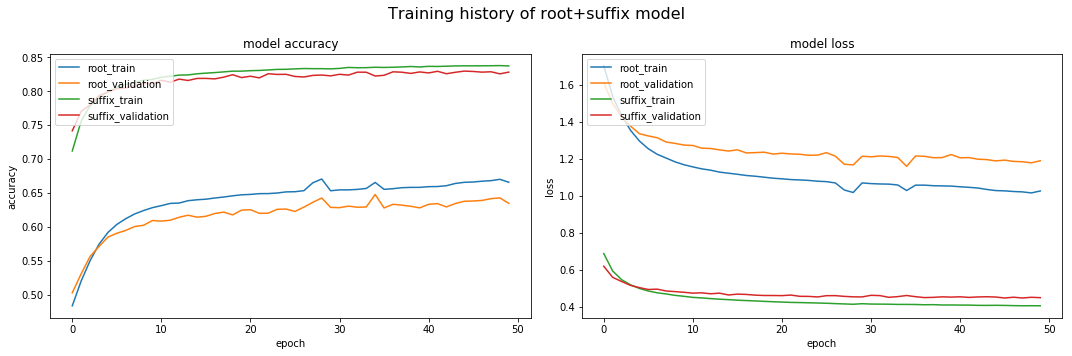

In [12]:
### Visualize model learning ###
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['dense_1_acc'])
plt.plot(history.history['val_dense_1_acc'])
plt.plot(history.history['dense_2_acc'])
plt.plot(history.history['val_dense_2_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['root_train', 'root_validation', 'suffix_train', 'suffix_validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['val_dense_1_loss'])
plt.plot(history.history['dense_2_loss'])
plt.plot(history.history['val_dense_2_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['root_train', 'root_validation', 'suffix_train', 'suffix_validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root+suffix model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [13]:
### Load best performance model ###
model = load_model("../../models/model-2_cc-7.h5")

In [14]:
### Evaluate predictions ###
[root_pred, suffix_pred] = model.predict([X_melody_test, X_roots_test, X_suffixes_test])

# Build tensor of combined predictions
chord_pred = np.zeros((len(test_index), n_chords), dtype='float32')
for i, (root_softmax, suffix_softmax) in enumerate(zip(root_pred, suffix_pred)):
    root_index = np.argmax(root_softmax)
    suffix_index = np.argmax(suffix_softmax)
    root_str = index_roots[root_index]
    suffix_str = index_suffixes[suffix_index]
    label = root_str + suffix_str if not root_str == 'NC' else 'NC' 
    chord_pred[i, chords_index[label]] = 1
    

# Compute accuracy and kappa score 
print("Categorical accuracy of root prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_roots_test, harmoutil.softmax_to_argmax(root_pred))))
print("Categorical accuracy of suffix prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_suffixes_test, harmoutil.softmax_to_argmax(suffix_pred))))
print("Categorical accuracy of combined chord prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_chords_test, chord_pred)))

print("Kappa score of root prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_roots_test, harmoutil.softmax_to_argmax(root_pred))))
print("Kappa score of suffix prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_suffixes_test, harmoutil.softmax_to_argmax(suffix_pred))))
print("Kappa score of combined chord prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_chords_test, chord_pred)))



Categorical accuracy of root prediction: 0.6438
Categorical accuracy of suffix prediction: 0.8278
Categorical accuracy of combined chord prediction: 0.5822
Kappa score of root prediction: 0.6115
Kappa score of suffix prediction: 0.5819
Kappa score of combined chord prediction: 0.5608


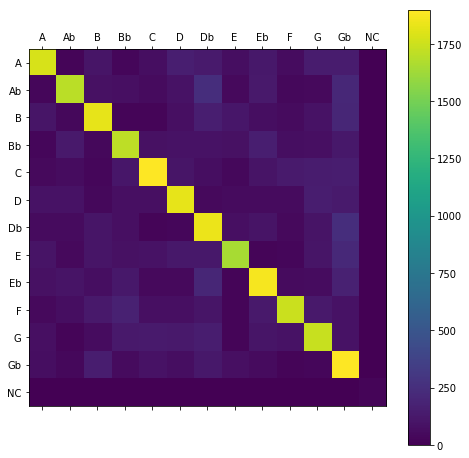

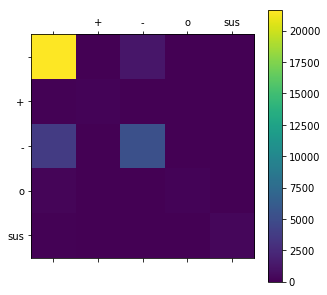

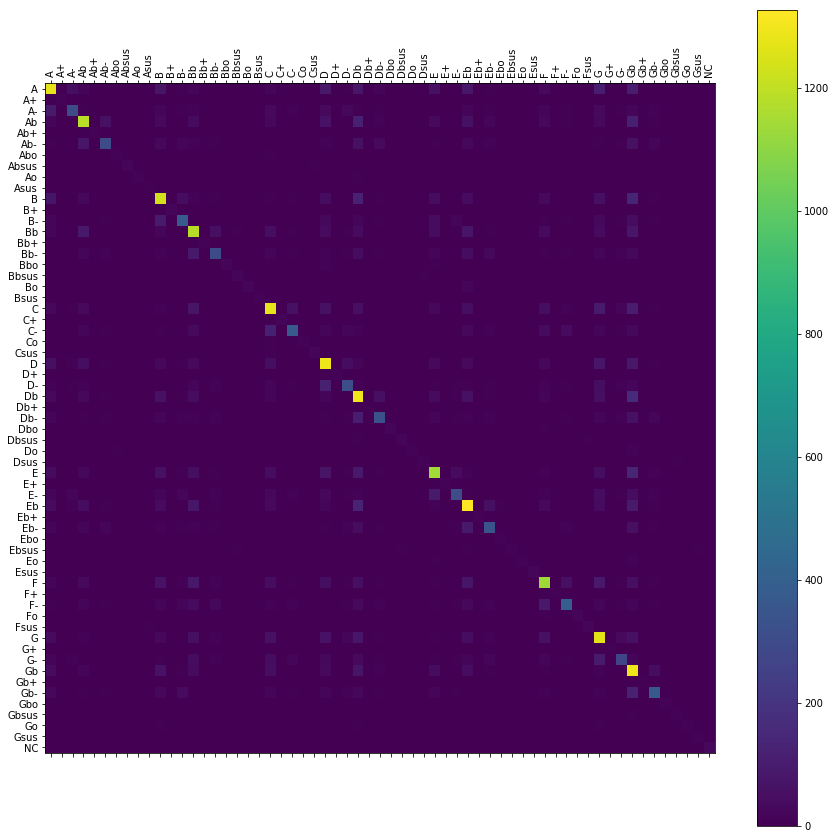

In [15]:
### Visualize prediction ###
root_test_labels = [index_roots[np.argmax(row)] for row in Y_roots_test]
root_pred_labels = [index_roots[np.argmax(row)] for row in root_pred]
suffix_test_labels = [index_suffixes[np.argmax(row)] for row in Y_suffixes_test]
suffix_pred_labels = [index_suffixes[np.argmax(row)] for row in suffix_pred]
chord_test_labels = [index_chords[np.argmax(row)] for row in Y_chords_test]
chord_pred_labels = [index_chords[np.argmax(row)] for row in chord_pred]

root_cm = confusion_matrix(root_test_labels, root_pred_labels)
suffix_cm = confusion_matrix(suffix_test_labels, suffix_pred_labels)
chord_cm = confusion_matrix(chord_test_labels, chord_pred_labels)

# Display confusion matrices
labels = sorted(list(set(root_test_labels)))
# print(labels)
plt.figure(figsize=(8,8))              # Create a new matplotlib.figure.Figure instance
ax = plt.axes()                 # Create a new matplotlib.axes.Axes instance
im = ax.matshow(root_cm)       # Axes.matshow returns a AxesImage instance
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.colorbar(im, ax=ax)               # Link a colorbar based on an AxesImage to the Figure
# ax.set_xticklabels(['']+labels) # Set the labels of the Axes
# ax.set_yticklabels(['']+labels) # Set the labels of the Axes
plt.show()

labels = sorted(list(set(suffix_test_labels)))
# print(labels)
plt.figure(figsize=(5,5))              
ax = plt.axes()                 
im = ax.matshow(suffix_cm)     
plt.colorbar(im, ax=ax)               
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
plt.show()

labels = sorted(list(set(chord_test_labels)))
# print(labels)
plt.figure(figsize=(15,15))              
ax = plt.axes()                 
im = ax.matshow(chord_cm)      
plt.colorbar(im, ax=ax)               
plt.xticks(np.arange(len(labels)), labels, rotation='vertical')
plt.yticks(np.arange(len(labels)), labels)
plt.show()


In [16]:
### Evaluate performnce in terms of note presence ###

# Convertroot+suffix prediction to note presence vector (as in Model 4)
converted_preds_list = []
for rt, sf in zip(root_pred, suffix_pred):
    suffix_label = index_suffixes[np.argmax(sf)]
    root_label = index_roots[np.argmax(rt)]
    if not root_label == 'NC':    
        note_positions = harmoutil.root_position(suffix_label)
        shift = harmoutil.root_index(root_label)
        note_presence = harmoutil.shift(note_positions, shift)
        if len(note_presence)>12:
            print(suffix_label, note_positions, root_label, shift, note_presence) 
    else:
        note_presence = [0]*12
        
    converted_preds_list.append(note_presence)
    
    
# Convert original groundtruth test set chords to note presence vector (as in Model 4)
converted_trues_list = []
for row in Y_chords_test:
    prediction = index_chords[np.argmax(row)]
    note_presence = harmoutil.chord_to_notes(prediction)
    converted_trues_list.append(note_presence)
    
# Create tesnsors of converted data
converted_preds = np.zeros((Y_chords_test.shape[0], 12), dtype='float32')
converted_trues = np.zeros((Y_chords_test.shape[0], 12), dtype='float32')
for i, (pred, true) in enumerate(zip(converted_preds_list, converted_trues_list)):
#     print(pred)
    for j, pred_pres in enumerate(pred):
#         print(j, pred_pres)
        converted_preds[i, j] = pred_pres
    for k, true_pres in enumerate(true):
        converted_trues[i, k] = true_pres
        
# Compute accuracy
print("Accuracy: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(converted_trues, converted_preds)))
print("Kappa: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(converted_trues, converted_preds)))
print("F-score: {0:.4f}".format(harmoutil.compute_binary_fscore(converted_trues, converted_preds)))

Accuracy: 0.8451
TP: 69111 TN: 269979 FP: 31089 FN: 31041
301020 301068
100200 100152
Kappa: 0.5867
F-score: 0.6899
